<a href="https://colab.research.google.com/github/juliadiepho/US_immigration_politcy_NLP_Project/blob/master/Julia_Ho_Program2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Program 2: Feature extraction and Matching

This is Program 2 for [COMSC 341-CV Computer Vision](https://sites.google.com/mtholyoke.edu/comsc341cv-fa23).

**Getting Started:**

To get started, download the source files [here](https://moodle.mtholyoke.edu/mod/assign/view.php?id=909003). You should see a Jupyter notebook file called `Program2.ipynb` and a separate `P2Data.zip` file that contains images we will use to test your program. To run the code, import the notebook into [Google Colaboratory](https://colab.research.google.com "Colab") by going to File->Upload Notebook in Colab and open the notebook `Program2.ipynb`.

**This project:**

In this project, you will implement interest point detection and descriptor extraction. This will build on the `im_util` functions you developed in Project 1. Once you have a basic feature matcher working, try out some improvements and document your results. You will then run the experiments on the images provided in `P2Data.zip`.

**What to turn in:**

Turn in (1) a PDF of your completed ipynb notebook and (2) the source .ipynb. Remember to clearly describe any enhancements or experiments you tried and answer any <font color='Tomato'>questions</font> in your ipynb notebook. Your writeup should be marked in <font color='MediumSeaGreen'>green</font>. Finally, submit the the PDF and notebook file on [Moodle](https://moodle.mtholyoke.edu/mod/assign/view.php?id=909003). Do NOT zip them together.

`ver. 100323`

In [63]:
import numpy as np
import os.path
from time import time
import types
import matplotlib.pyplot as plt

%matplotlib inline
# edit this line to change the figure size
plt.rcParams['figure.figsize'] = (12.0, 8.0)
# force auto-reload of import modules before running code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# run this command to unzip the images in colab
!unzip -n -d data P2Data.zip

Archive:  P2Data.zip


### im_util.py
Make a copy of your completed `im_util.py` code cell from Program1 to the code cell below. You do NOT need to make further changes to this part of the code for this assignment.

In [65]:
# Copyright 2017 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import math
import numpy as np
import PIL.Image as pil
import scipy.signal as sps
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def convolve_1d(x, k):
  """
  Convolve vector x with kernel k

  Inputs: x=input vector (Nx)
          k=input kernel (Nk)

  Outputs: y=output vector (Nx)
  """
  y=np.zeros_like(x)

  """
  *******************************************
  *** TODO: write code to perform convolution
  *******************************************

  The output should be the same size as the input
  You can assume zero padding, and an odd-sized kernel
  """

  """
  *******************************************
  """

  vector_size = len(x)
  kernel_size = len(k)

  # flip the kernel
  k_flipped = np.array(k[::-1])
  x_padded = np.array(x)

  # convolution output
  for i in range(0, vector_size):
    y[i] = np.sum(x_padded[max(0, i - kernel_size + 1):i + 1] * k_flipped[max(kernel_size - i - 1, 0):])

  return y

def convolve_rows(im, k):
  """
  Convolve image im with kernel k

  Inputs: im=input image (H, W, B)
          k=1D convolution kernel (N)

  Outputs: im_out=output image (H, W, B)
  """
  im_out = np.zeros_like(im)

  """
  *****************************************
  *** TODO: write code to convolve an image
  *****************************************

  Convolve the rows of image im with kernel k
  The output should be the same size as the input
  You can assume zero padding, and an odd-sized kernel
  """

  # extract the info of the input impage
  h, w, b = im.shape

  # flip the kernel
  k_flipped = np.array(k[::-1])

  # perform rows convolution by looping through each row of the image
  for i in range(h):
    for j in range(b):
      # extract a single row
      row = im[i, :, j]
      im_out[i, :, j] = convolve_1d(row, k_flipped)

  """
  *****************************************
  """

  return im_out

def gauss_kernel(sigma):
  """
  1D Gauss kernel of standard deviation sigma
  """
  l = int(np.ceil(2 * sigma))
  x = np.linspace(-l, l, 2*l+1)

  # # FORNOW
  # gx = np.zeros_like(x)

  """
  *******************************************
  *** TODO: compute gaussian kernel at each x
  *******************************************
  """
  # Compute gaussian kernel at each x
  gx = np.exp(-x**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
  """
  *******************************************
  """
  # reshaping
  gx = np.expand_dims(gx,0)
  return gx

def convolve_gaussian(im, sigma):
  """
  2D gaussian convolution
  """
  imc=np.zeros_like(im)

  """
  ***************************************
  *** TODO separable gaussian convolution
  ***************************************
  """
  # 1D gaussian kernel of the rows
  gauss_kern = gauss_kernel(sigma)

  # perform image convolution with the 1D gaussian kernel
  imc = convolve_rows(im, gauss_kern[0])

  # transpose imc back to its orginal shape
  imc = convolve_rows(imc.transpose(1, 0, 2), gauss_kern[0]).transpose(1, 0, 2)
  """
  ***************************************
  """
  return imc

def compute_gradients(img):

  Ix=np.zeros_like(img)
  Iy=np.zeros_like(img)

  """
  ***********************************************
  *** TODO: write code to compute image gradients
  ***********************************************
  """
  # extract the size of the input image
  h, w, b = img.shape

  # compute gradients using finite differences
  for y in range(1, h - 1):
      for x in range(1, w - 1):
        # compute x-gradient (Ix)
        Ix[y, x] = (img[y, x + 1] - img[y, x - 1]) / 2.0

        # Compute y-gradient (Iy)
        Iy[y, x] = (img[y + 1, x] - img[y - 1, x]) / 2.0

  """
  ***********************************************
  """
  return Ix, Iy

def compute_sobel(img):

  Sx=np.zeros_like(img)
  Sy=np.zeros_like(img)

  """
  ***********************************************
  *** TODO: write code to conduct sobel edge detection
  ***********************************************
  """
  # extract dimensions of the input image
  h, w = img.shape[:2]

  # Sobel kernels
  kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

  # loop through the pixels that are in the inner side of the image
  for y in range(1, h - 1):
      for x in range(1, w - 1):
          # x-gradient (Sx) using the Sobel kernel
          Sx[y, x] = np.sum(img[y - 1:y + 2, x - 1:x + 2] * kernel_x)

          # y-gradient (Sy) using the Sobel kernel
          Sy[y, x] = np.sum(img[y - 1:y + 2, x - 1:x + 2] * kernel_y)

  return Sx, Sy

  """
  ***********************************************
  """
  return Sx, Sy

def image_open(filename):
  """
  Returns a numpy float image with values in the range (0,1)
  """
  pil_im = pil.open(filename)
  im_np = np.array(pil_im).astype(np.float32)
  im_np /= 255.0
  return im_np

def image_save(im_np, filename):
  """
  Saves a numpy float image to file
  """
  if (len(im_np.shape)==2):
    im_np = np.expand_dims(im_np, 2)
  if (im_np.shape[2]==1):
    im_np= np.repeat(im_np, 3, axis=2)
  im_np = np.maximum(0.0, np.minimum(im_np, 1.0))
  pil_im = pil.fromarray((im_np*255).astype(np.uint8))
  pil_im.save(filename)

def image_figure(im, dpi=100):
  """
  Creates a matplotlib figure around an image,
  useful for writing to file with savefig()
  """
  H,W,_=im.shape
  fig=plt.figure()
  fig.set_size_inches(W/dpi, H/dpi)
  ax=fig.add_axes([0,0,1,1])
  ax.imshow(im)
  return fig, ax

def plot_many_images(*imgs):
  """
  Plot two images and return axis handles
  """
  count = len(imgs)
  axs = []
  for i in range(count):
    axs.append(plt.subplot(1,count,i+1))
    plt.imshow(imgs[i])
    plt.axis('off')
  return axs

def normalise_01(im):
  """
  Normalise image to the range (0,1)
  """
  mx = im.max()
  mn = im.min()
  den = mx-mn
  small_val = 1e-9
  if (den < small_val):
    print('image normalise_01 -- divisor is very small')
    den = small_val
  return (im-mn)/den

def grey_to_rgb(img):
  """
  Convert greyscale to rgb image
  """
  if (len(img.shape)==2):
    img = np.expand_dims(img, 2)

  img3 = np.repeat(img, 3, 2)
  return img3

def disc_mask(l):
  """
  Create a binary cirular mask of radius l
  """
  sz = 2 * l + 1
  m = np.zeros((sz,sz))
  x = np.linspace(-l,l,2*l+1)/l
  x = np.expand_dims(x, 1)
  m = x**2
  m = m + m.T
  m = m<1
  m = np.expand_dims(m, 2)
  return m

def convolve(im, kernel):
  """
  Wrapper for scipy convolution function
  This implements a general 2D convolution of image im with kernel
  Note that strictly speaking this is correlation not convolution

  Inputs: im=input image (H, W, B) or (H, W)
          kernel=kernel (kH, kW)

  Outputs: imc=output image (H, W, B)
  """
  if (len(im.shape)==2):
    im = np.expand_dims(im, 2)
  H, W, B = im.shape
  imc = np.zeros((H, W, B))
  for band in range(B):
    imc[:, :, band] = sps.correlate2d(im[:, :, band], kernel, mode='same')
  return imc

def coordinate_image(num_rows,num_cols,r0,r1,c0,c1):
  """
  Creates an image size num_rows, num_cols
  with coordinates linearly spaced in from r0->r1 and c0->c1
  """
  rval=np.linspace(r0,r1,num_rows)
  cval=np.linspace(c0,c1,num_cols)
  c,r=np.meshgrid(cval,rval)
  M = np.stack([r,c,np.ones(r.shape)],-1)
  return M

def transform_coordinates(coord_image, M):
  """
  Transform an image containing row,col,1 coordinates by matrix M
  """
  M=np.expand_dims(M,2)
  uh=np.dot(coord_image,M.T)
  uh=uh[:, :, 0, :]
  uh=uh/np.expand_dims(uh[:, :, 2],2)
  return uh

def warp_image(im, coords):
  """
  Warp image im using row,col,1 image coords
  """
  im_rows,im_cols,im_bands=im.shape
  warp_rows,warp_cols,_=coords.shape
  map_coords=np.zeros((3,warp_rows,warp_cols,im_bands))
  for b in range(im_bands):
    map_coords[0,:,:,b]=coords[:,:,0]
    map_coords[1,:,:,b]=coords[:,:,1]
    map_coords[2,:,:,b]=b
  warp_im = map_coordinates(im, map_coords, order=1)
  return warp_im

# allow accessing these functions by im_util.*
im_util=types.SimpleNamespace()
im_util.convolve_1d=convolve_1d
im_util.convolve_rows=convolve_rows
im_util.gauss_kernel=gauss_kernel
im_util.convolve_gaussian=convolve_gaussian
im_util.compute_gradients=compute_gradients
im_util.compute_sobel=compute_sobel
im_util.image_open=image_open
im_util.image_save=image_save
im_util.image_figure=image_figure
im_util.plot_many_images=plot_many_images
im_util.normalise_01=normalise_01
im_util.grey_to_rgb=grey_to_rgb
im_util.disc_mask=disc_mask
im_util.convolve=convolve
im_util.coordinate_image=coordinate_image
im_util.transform_coordinates=transform_coordinates
im_util.warp_image=warp_image

### interest_point.py

In [66]:
# Copyright 2017 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import math

import numpy as np
import scipy.ndimage as spy
from scipy.ndimage import filters, map_coordinates, rotate
from scipy import stats
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

# import im_util.py

class InterestPointExtractor:
  """
  Class to extract interest points from an image
  """
  def __init__(self):
    self.params={}
    self.params['border_pixels']=10
    self.params['strength_threshold_percentile']=95
    self.params['supression_radius_frac']=0.01
    self.DOG = 1
    self.HARRIS_SIM = 2
    self.HARRIS_HAR = 3

  def find_interest_points(self, img):
    """
    Find interest points in greyscale image img

    Inputs: img=greyscale input image (H, W, 1)

    Outputs: ip=interest points of shape (2, N)
    """
    ip_fun = self.corner_function(img)
    row, col = self.find_local_maxima(ip_fun)

    ip = np.stack((row,col))
    return ip

  def dog_corner(self, img):
    """
    Compute DOG corner strength function in image im

    Inputs: img=grayscale input image (H, W, 1)

    Outputs: ip_fun=interest point strength function (H, W, 1)
    """
    H, W, _ = img.shape

    # FORNOW: random interest point function
    ip_fun = np.random.randn(H, W, 1)
    """
    **********************************************************
    *** TODO: write code to compute a DOG corner function
    **********************************************************
    """

    # convolution of gaussian kernels
    # 3.0: sigma of larger gaussian kernel
    # 2.0: sigma of smaller gaussian kernel
    large_gauss = im_util.convolve_gaussian(img, 3.0)
    small_gauss = im_util.convolve_gaussian(img, 2.0)

    # compute the DOG
    ip_fun = large_gauss - small_gauss
    """
    **********************************************************
    """
    return ip_fun

  def harris_corner(self, img, corner_fn):
    """
    Compute two HARRIS corner strength function in image im

    Inputs: img=grayscale input image (H, W, 1)
            corner_fn=2: for SIMPLE HARRIS detection
                      3: for HARMONIC HARRIS detection

    Outputs: ip_fun=interest point strength function (H, W, 1)
    """
    H, W, _ = img.shape

    # FORNOW: random interest point function
    ip_fun = np.random.randn(H, W, 1)
    """
    **********************************************************
    *** TODO: write code to compute HARRIS corner functions
    **********************************************************
    """
    # harris corner parameter
    alpha = 0.04
    sigma = 1.0

    # compute image gradients Ix and Iy
    Ix, Iy = im_util.compute_gradients(img)

    # compute Ixy, Ixx, Iyy
    Ixy = Ix * Iy
    Ixx = Ix * Ix
    Iyy = Iy * Iy

    # covariance matrix M
    M = np.array([[Ixx, Ixy],[Ixy, Iyy]])

    Ixy_smoothed = im_util.convolve_gaussian(Ixy, sigma)
    Ixx_smoothed = im_util.convolve_gaussian(Ixx, sigma)
    Iyy_smoothed = im_util.convolve_gaussian(Iyy, sigma)

    # compute corner response scores R and f
    det_M = Ixx_smoothed * Iyy_smoothed - Ixy_smoothed ** 2
    trace_M = Ixx_smoothed + Iyy_smoothed

    # simple Harris corner detection
    if corner_fn == 2:
      R = det_M - alpha * (trace_M ** 2)
      ip_fun = R

    # harmonic harris corner detection
    if corner_fn == 3:
      # avoid zero division
      f = det_M / (trace_M + 1e-9)
      ip_fun = f

    """
    **********************************************************
    """
    return ip_fun

  def corner_function(self, img, corner_fn=1):
    """
    Compute corner strength function in image im

    Inputs: img=grayscale input image (H, W, 1)
            corner_fn=1: for DOG corner detection
                      2: for SIMPLE HARRIS detection
                      3: for HARMONIC HARRIS detection

    Outputs: ip_fun=interest point strength function (H, W, 1)
    """
    H, W, _ = img.shape

    if corner_fn == self.HARRIS_SIM or corner_fn == self.HARRIS_HAR:
      ip_fun = self.harris_corner(img, corner_fn)

    elif corner_fn == self.DOG:
      ip_fun = self.dog_corner(img)

    else:
      print("Your choice of corner_fn is invalid. (Please select: 1,2, or 3)")
      # random interest point function
      ip_fun = np.random.randn(H, W, 1)

    return ip_fun


  def find_local_maxima(self, ip_fun):
    """
    Find local maxima in interest point strength function

    Inputs: ip_fun=corner strength function (H, W, 1)

    Outputs: row,col=coordinates of interest points
    """

    H, W, _ = ip_fun.shape

    # radius for non-maximal suppression
    suppression_radius_pixels = int(self.params['supression_radius_frac']*max(H, W))

    # minimum of strength function for corners
    strength_threshold=np.percentile(ip_fun, self.params['strength_threshold_percentile'])

    # don't return interest points within border_pixels of edge
    border_pixels = self.params['border_pixels']

    # row and column coordinates of interest points
    row = []
    col = []

    # FORNOW: random row and column coordinates
    # row = np.random.randint(0,H,100)
    # col = np.random.randint(0,W,100)

    """
    ***************************************************
    *** TODO: write code to find local maxima in ip_fun
    ***************************************************

    Hint: try scipy maximum_filter with im_util.disc_mask
    """
    mask = im_util.disc_mask(suppression_radius_pixels)

    # coordinates of interest points
    indices = np.argwhere((ip_fun == spy.maximum_filter(ip_fun, footprint=mask)) & (ip_fun > strength_threshold))
    row, col = indices[:, 0], indices[:, 1]


    # filter out points within image border
    valid_indices = (row >= border_pixels) & (row < (H - border_pixels)) & (col >= border_pixels) & (col < (W - border_pixels))
    row, col = row[valid_indices], col[valid_indices]
    """
    ***************************************************
    """

    return row, col

class DescriptorExtractor:
  """
  Extract descriptors around interest points
  """
  def __init__(self):
    self.params={}
    self.params['patch_size']=8
    # FORNOW:   self.params['ratio_threshold']=1.0
    self.params['ratio_threshold']=0.6

  def get_descriptors(self, img, ip):
    """
    Extact descriptors from grayscale image img at interest points ip

    Inputs: img=grayscale input image (H, W, 1)
            ip=interest point coordinates (2, N)

    Returns: descriptors=vectorized descriptors (N, num_dims)
    """
    patch_size=self.params['patch_size']
    patch_size_div2=int(patch_size/2)
    num_dims=patch_size**2

    H,W,_=img.shape
    num_ip=ip.shape[1]
    descriptors=np.zeros((num_ip,num_dims))


    for i in range(num_ip):
      row=ip[0,i]
      col=ip[1,i]

      # FORNOW: random image patch
      patch=np.random.randn(patch_size,patch_size)

      """
      ******************************************************
      *** TODO: write code to extract descriptor at row, col
      ******************************************************
      """
      # control sample spacing
      # extract the descriptor patch around interest point
      patch = img[row - patch_size_div2:row + patch_size_div2, col - patch_size_div2:col + patch_size_div2, 0]

      # flatten the patch into a 1D vector
      descriptors[i, :] = patch.flatten()


      """
      ******************************************************
      """

      descriptors[i, :]=np.reshape(patch,num_dims)

    # normalise descriptors to 0 mean, unit length
    mn=np.mean(descriptors,1,keepdims=True)
    sd=np.std(descriptors,1,keepdims=True)
    small_val = 1e-6
    descriptors = (descriptors-mn)/(sd+small_val)

    return descriptors

  def compute_distances(self, desc1, desc2):
    """
    Compute distances between descriptors

    Inputs: desc1=descriptor array (N1, num_dims)
            desc2=descriptor array (N2, num_dims)

    Returns: dists=array of distances (N1,N2)
    """
    N1,num_dims=desc1.shape
    N2,num_dims=desc2.shape

    #FORNOW
    dists= np.zeros((N1, N2))
    """
    ******************************************************
    *** TODO: write code calculate distance between desc1 and desc2
    ******************************************************
    """
    desc1_expanded = np.expand_dims(desc1, axis=1)
    desc2_expanded = np.expand_dims(desc2, axis=0)
    squared_diff = (desc1_expanded - desc2_expanded) ** 2
    dists = np.sqrt(np.sum(squared_diff, axis=2))

    """
    ******************************************************
    """
    return dists

  def match_descriptors(self, desc1, desc2):
    """
    Find nearest neighbour matches between descriptors

    Inputs: desc1=descriptor array (N1, num_dims)
            desc2=descriptor array (N2, num_dims)

    Returns: match_idx=nearest neighbour index for each desc1 (N1)
    """
    dists=self.compute_distances(desc1, desc2)

    match_idx=np.argmin(dists,1)

    return match_idx

  def match_ratio_test(self, desc1, desc2):
    """
    Find nearest neighbour matches between descriptors
    and perform ratio test

    Inputs: desc1=descriptor array (N1, num_dims)
            desc2=descriptor array (N2, num_dims)

    Returns: match_idx=nearest neighbour inded for each desc1 (N1)
             ratio_pass=whether each match passes ratio test (N1)
    """
    N1,num_dims=desc1.shape

    dists=self.compute_distances(desc1, desc2)

    sort_idx=np.argsort(dists,1)

    #match_idx=np.argmin(dists,1)
    match_idx=sort_idx[:,0]

    d1NN=dists[np.arange(0,N1),sort_idx[:,0]]
    d2NN=dists[np.arange(0,N1),sort_idx[:,1]]

    ratio_threshold=self.params['ratio_threshold']
    ratio_pass=(d1NN<ratio_threshold*d2NN)

    return match_idx,ratio_pass

def draw_interest_points_ax(ip, ax):
  """
  Draw interest points ip on axis ax
  """
  for row,col in zip(ip[0,:],ip[1,:]):
    circ1 = Circle((col,row), 5)
    circ1.set_color('black')
    circ2 = Circle((col,row), 3)
    circ2.set_color('white')
    ax.add_patch(circ1)
    ax.add_patch(circ2)

def draw_interest_points_file(im, ip, filename):
  """
  Draw interest points ip on image im and save to filename
  """
  fig,ax = im_util.image_figure(im)
  draw_interest_points_ax(ip, ax)
  fig.savefig(filename)
  plt.close(fig)

def draw_matches_ax(ip1, ipm, ax1, ax2):
  """
  Draw matches ip1, ipm on axes ax1, ax2
  """
  for r1,c1,r2,c2 in zip(ip1[0,:], ip1[1,:], ipm[0,:], ipm[1,:]):
    rand_colour=np.random.rand(3,)

    circ1 = Circle((c1,r1), 5)
    circ1.set_color('black')
    circ2 = Circle((c1,r1), 3)
    circ2.set_color(rand_colour)
    ax1.add_patch(circ1)
    ax1.add_patch(circ2)

    circ3 = Circle((c2,r2), 5)
    circ3.set_color('black')
    circ4 = Circle((c2,r2), 3)
    circ4.set_color(rand_colour)
    ax2.add_patch(circ3)
    ax2.add_patch(circ4)

def draw_matches_file(im1, im2, ip1, ipm, filename):
  """
  Draw matches ip1, ipm on images im1, im2 and save to filename
  """
  H1,W1,B1=im1.shape
  H2,W2,B2=im2.shape

  im3 = np.zeros((max(H1,H2),W1+W2,3))
  im3[0:H1,0:W1,:]=im1
  im3[0:H2,W1:(W1+W2),:]=im2

  fig,ax = im_util.image_figure(im3)
  col_offset=W1

  for r1,c1,r2,c2 in zip(ip1[0,:], ip1[1,:], ipm[0,:], ipm[1,:]):
    rand_colour=np.random.rand(3,)

    circ1 = Circle((c1,r1), 5)
    circ1.set_color('black')
    circ2 = Circle((c1,r1), 3)
    circ2.set_color(rand_colour)
    ax.add_patch(circ1)
    ax.add_patch(circ2)

    circ3 = Circle((c2+col_offset,r2), 5)
    circ3.set_color('black')
    circ4 = Circle((c2+col_offset,r2), 3)
    circ4.set_color(rand_colour)
    ax.add_patch(circ3)
    ax.add_patch(circ4)

  fig.savefig(filename)
  plt.close(fig)

def plot_descriptors(desc,plt):
  """
  Plot a random set of descriptor patches
  """
  num_ip,num_dims = desc.shape
  patch_size = int(np.sqrt(num_dims))

  N1,N2=2,8
  figsize0=plt.rcParams['figure.figsize']
  plt.rcParams['figure.figsize'] = (16.0, 4.0)
  for i in range(N1):
    for j in range(N2):
      ax=plt.subplot(N1,N2,i*N2+j+1)
      rnd=np.random.randint(0,num_ip)
      desc_im=np.reshape(desc[rnd,:],(patch_size,patch_size))
      plt.imshow(im_util.grey_to_rgb(im_util.normalise_01(desc_im)))
      plt.axis('off')

  plt.rcParams['figure.figsize']=figsize0

def plot_matching_descriptors(desc1,desc2,desc1_id,desc2_id,plt):
  """
  Plot a random set of matching descriptor patches
  """
  num_inliers=desc1_id.size
  num_ip,num_dims = desc1.shape
  patch_size=int(np.sqrt(num_dims))

  figsize0=plt.rcParams['figure.figsize']

  N1,N2=1,8
  plt.rcParams['figure.figsize'] = (16.0, N1*4.0)

  for i in range(N1):
    for j in range(N2):
      rnd=np.random.randint(0,num_inliers)

      desc1_rnd=desc1_id[rnd]
      desc2_rnd=desc2_id[rnd]

      desc1_im=np.reshape(desc1[desc1_rnd,:],(patch_size,patch_size))
      desc2_im=np.reshape(desc2[desc2_rnd,:],(patch_size,patch_size))

      ax=plt.subplot(2*N1,N2,2*i*N2+j+1)
      plt.imshow(im_util.grey_to_rgb(im_util.normalise_01(desc1_im)))
      plt.axis('off')
      ax=plt.subplot(2*N1,N2,2*i*N2+N2+j+1)
      plt.imshow(im_util.grey_to_rgb(im_util.normalise_01(desc2_im)))
      plt.axis('off')

  plt.rcParams['figure.figsize'] = figsize0

# allow accessing these functions by interest_point.*
interest_point=types.SimpleNamespace()
interest_point.InterestPointExtractor=InterestPointExtractor
interest_point.DescriptorExtractor=DescriptorExtractor
interest_point.draw_interest_points_ax=draw_interest_points_ax
interest_point.draw_interest_points_file=draw_interest_points_file
interest_point.draw_matches_ax=draw_matches_ax
interest_point.draw_matches_file=draw_matches_file
interest_point.plot_descriptors=plot_descriptors
interest_point.plot_matching_descriptors=plot_matching_descriptors

### Tests for interest_point.py (Part I): Interest Point Extractor

Now you will use these convolution functions to implement three interest point detectors - DoG, Simple Harris, and Harmonic Harris. To do that, you will complete the functions in `dog_corner` and `harris_corner` in the `InterestPointExtractor` class. Run the code below to visualise your corner function output.

<font color='Tomato'>Q1: Explain the difference between the three corner detectors - both in terms of derivation and resultant corner strength maps.</font>

 <font color='MediumSeaGreen'>Ans:</font>
 (1) DoG corner detector uses the difference between two Gaussian-blurred versions of the image to find regions/points with significant changes in intensity. The resultant corner strength map represents both corners and edges.

 (2) Simple Harris corner detector computes the eigenvalues of the gradients of the image (or the first derivative) with respect to x-axis and y-axis. For each pixel, the covariance matrix M is then formed and we then calculate the eigenvalues of the matrix M. Corner is detected when the eigenvalues are large. This detector produces a corner strength map where the highly positive values represent corners and are highlighted, and low values represent non-corner regions.

 (3) Harmonic Harris corner detector is similar to the Simple Harris, but it also uses a harmonic mean of the eigenvalues, making it more robust to noise and varied illumination conditions. The corner strength map is also similar to that of Simple Harris, where highly positive values represent corners.




[ Compute corner strength ]

Below shows corner strength maps using  DoG (left) , simple Harris (middle) , harmonic Harris (right)


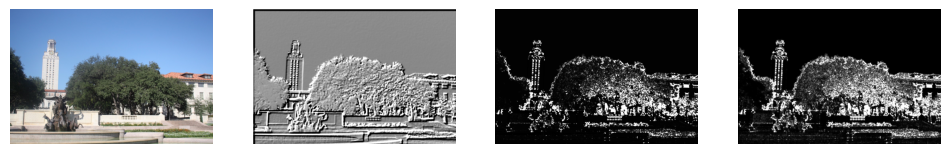

In [67]:
"""
Compute corner strength function
"""
# load image
image_filename='data/P2Data/foto1A.jpg'
im = im_util.image_open(image_filename)

# convert image to grayscale
img = np.mean(im,2,keepdims=True)

print('[ Compute corner strength ]')

cf = ['DoG (left)', 'simple Harris (middle)', 'harmonic Harris (right)']
print('\nBelow shows corner strength maps using ',cf[0],',',cf[1],',',cf[2])

numFun = 3
small_val=1e-9
ip_ex = interest_point.InterestPointExtractor()
ip_fun = []
ip_fun_norm = []

for i in range(numFun):
  # calulate corner strength
  ip_fun.append(ip_ex.corner_function(img,i+1))

  # normalise for display
  [mn,mx]=np.percentile(ip_fun[i],[5,95])
  ip_fun_norm.append((ip_fun[i]-mn)/(mx-mn+small_val))
  ip_fun_norm[i]=np.maximum(np.minimum(ip_fun_norm[i],1.0),0.0)
  ip_fun_norm[i]=im_util.grey_to_rgb(ip_fun_norm[i])

axs=im_util.plot_many_images(im, ip_fun_norm[0], ip_fun_norm[1], ip_fun_norm[2])


Next detect corners as local maxima of this function by filling in `find_local_maxima` in the same class. <font color='Tomato'>Q2: What do you observe about the 3 sets of corners detected?</font>

 <font color='MediumSeaGreen'>Ans:</font> I noticed that when we use DoG, we got the least number of corners detected and the numbner is quite different from the other two resulting numbers. For Simple Harris and Harmonic Harris, the number of corners detected for each are quite similar to the other- there is not a big difference between the two numbers and they are both smaller than that of the number detected from DoG. I also noticed in the corners set for DoG, there seems to be more edge points detected, especially along the walls.

[ Find local maxima ]

Below shows the detected corners using  DoG (left) , simple Harris (middle) , harmonic Harris (right)
DoG (left) :  461 corners detected
simple Harris (middle) :  565 corners detected
harmonic Harris (right) :  596 corners detected


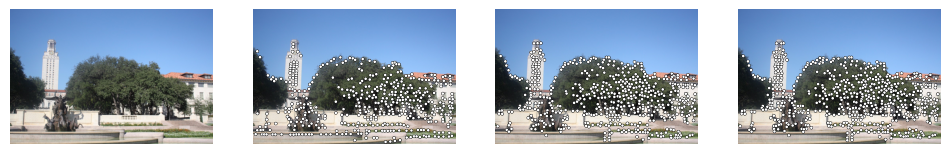

In [68]:
"""
Find local maxima of corner strength
"""
print('[ Find local maxima ]')
print('\nBelow shows the detected corners using ',cf[0],',',cf[1],',',cf[2])
# print the corner strength functions
axs=im_util.plot_many_images(im, im, im, im)

ip = []
for i in range(numFun):
  row, col = ip_ex.find_local_maxima(ip_fun[i])
  ip.append(np.stack((row,col)))
  print(cf[i], ': ',str(ip[i].shape[1]) , 'corners detected')
  interest_point.draw_interest_points_ax(ip[i], axs[i+1])

### Tests for interest_point.py (Part II): Descriptors and Matching

Now let's match our interest points. Start by extracting a very simple descriptor that is simply a patch of pixels around the interest point. To do this, fill in the function `get_descriptors` and `compute_distances` in the `DescriptorExtractor` class. The following code outputs a random sample of normalised descriptor patches. Check that the output looks sensible. Once you have this working, try varying the sample spacing in your descriptor patch.
<font color='Tomato'>Q3: What problem exists with sample spacings > 1 pixel? Q4: How can this be fixed?</font>

 <font color='MediumSeaGreen'>Ans:</font> Q3: I think the problem with sample spacings > 1 pixel is that the descriptor can be less detailed. The patch become larger, but the number of pixels within that patch is still the same. This can lead to descriptors missing some fine-scale details in the image. That local image maynot be as accurately presented by the descriptor. In terms of the specific code in this assignment, I tried implementing a variable that let us control the sample spacing, but the error was that there was a mismatch in the array sizes, specifically between the descriptor dimensions and the patch size.

Q4: To address this, I think we have to adjust the patch size, specifically increase it proportionally based on whatever sample spacing we choose so that the patch size aligns and covers the same area as the original patch.

[ Extract descriptors ]


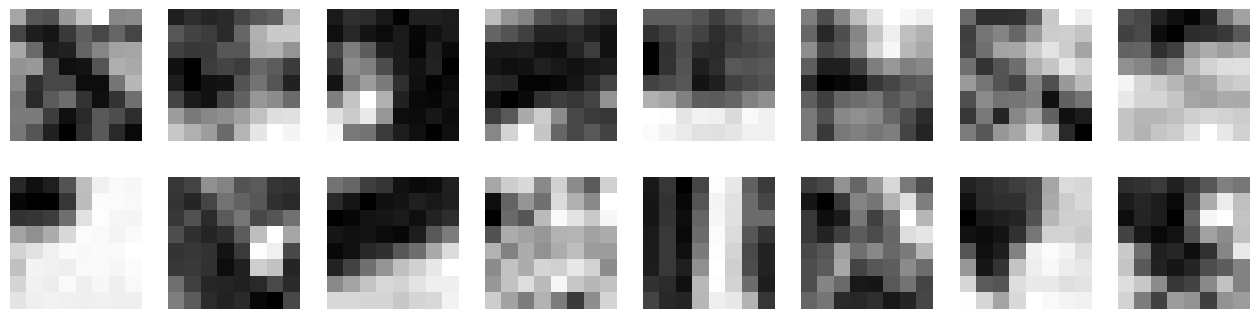

In [69]:
"""
Extract descriptors
sample_spacing=1.0
"""
print('[ Extract descriptors ]')
desc_ex=interest_point.DescriptorExtractor()
descriptors=desc_ex.get_descriptors(img, ip[0])
interest_point.plot_descriptors(descriptors,plt)

We will now match descriptors between a pair of images. Run the following two code blocks to extract your interest points and extract and match descriptors. The second code block calls a function to perform nearest-neighbour matching of descriptors and filtering using a ratio test. Take a look at the code and check you understand how it works.

[ find interest points ]
 found 461 in image 1
 found 447 in image 2

 elapse time:  44.43 secs 

[ drawing interest points ]

 elapse time:  5.80 secs 


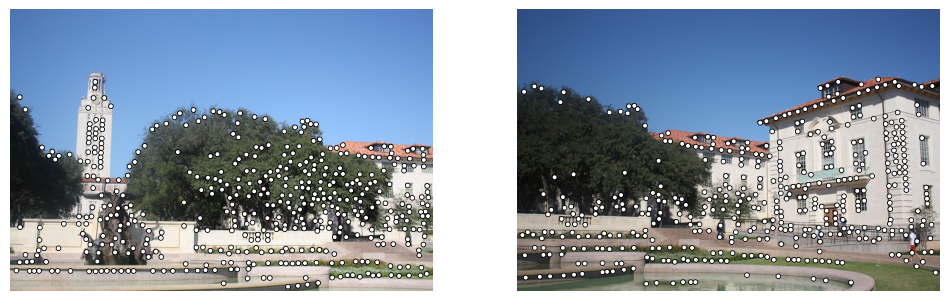

In [70]:
"""
Read a pair of input images and extract interest points
"""
image_dir='data/P2Data/'
im_filename1=image_dir+'foto1A.jpg' # can change to 'foto2A.jpg'
im_filename2=image_dir+'foto1B.jpg' # can change to 'foto2B.jpg'

im1 = im_util.image_open(im_filename1)
im2 = im_util.image_open(im_filename2)

img1 = np.mean(im1, 2, keepdims=True)
img2 = np.mean(im2, 2, keepdims=True)

print('[ find interest points ]')
t0=time()
ip_ex = interest_point.InterestPointExtractor()
ip1 = ip_ex.find_interest_points(img1)
print(' found '+str(ip1.shape[1])+' in image 1')
ip2 = ip_ex.find_interest_points(img2)
print(' found '+str(ip2.shape[1])+' in image 2')
t1=time()
print('\n elapse time: % .2f secs ' % (t1-t0))

print('\n[ drawing interest points ]')
ax1,ax2=im_util.plot_many_images(im1,im2)
t0=time()
interest_point.draw_interest_points_ax(ip1, ax1)
interest_point.draw_interest_points_ax(ip2, ax2)
t1=time()
print('\n elapse time: % .2f secs ' % (t1-t0))

[ extract descriptors ]
  0.02 secs
[ match descriptors ]
 Number of interest points = 461
 Number of matches passing ratio test = 17


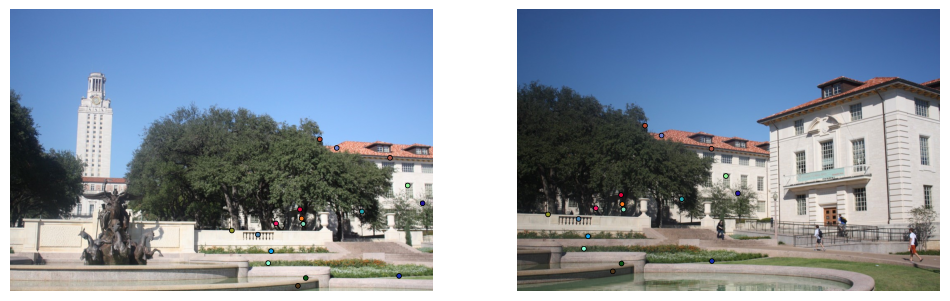

In [71]:
"""
Extract and match descriptors
"""
print('[ extract descriptors ]')
t0=time()
desc_ex = interest_point.DescriptorExtractor()
desc1 = desc_ex.get_descriptors(img1, ip1)
desc2 = desc_ex.get_descriptors(img2, ip2)
t1=time()
print(' % .2f secs' % (t1-t0))

print('[ match descriptors ]')
match_idx,ratio_pass=desc_ex.match_ratio_test(desc1, desc2)
num_ratio_pass=np.sum(ratio_pass)

ipm=ip2[:,match_idx]

ip1r=ip1[:,ratio_pass]
ip2r=ipm[:,ratio_pass]

N1,num_dims=desc1.shape
print(' Number of interest points = '+str(N1))
print(' Number of matches passing ratio test = '+str(num_ratio_pass))

ax1,ax2=im_util.plot_many_images(im1,im2)
interest_point.draw_matches_ax(ip1r, ip2r, ax1, ax2)


The following code visualises matched descriptor patches. <font color='Tomato'>Q5: Can you distinguish the correct and incorrect matches?</font> (reload to get another random sample).

 <font color='MediumSeaGreen'>Ans:</font> Based on the images, I think all of the pairs of point match with a very high accuracy. For example, the dark orange pair matches the edge of the roof. The light green pair matches the window of the building. For all other pairs, the locations are also precisely matched in two pictures. It is quite surprised to me that there seems to be no visible incorrect matches in the result.

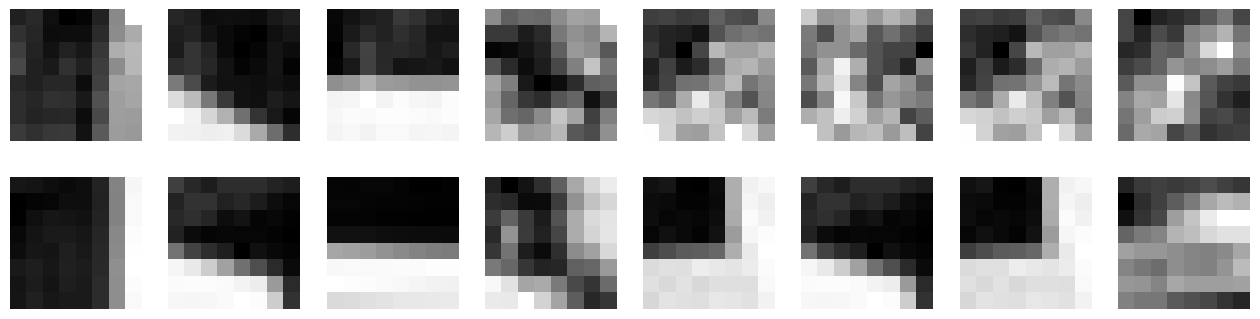

In [72]:
"""
Plot descriptors for matched points
"""
interest_point.plot_matching_descriptors(desc1,desc2,np.arange(0,ip1.shape[1]),match_idx,plt)

### Tests for interest_point.py (Part III): Improving Feature Matching

Try varying the `ratio_threshold` parameter in the descriptor matcher (`DescriptorExtractor` class params). <font color='Tomato'>Q6: What are good settings for this parameter?</font> Try testing the experimentally optimized parameter value on the other set of images `foto2A.jpg` and `foto2B.jpg`. <font color='Tomato'>Q7: Does it also yield good results?</font>

 <font color='MediumSeaGreen'>Ans:</font>

 If everything is working, you should see a good set of correctly matched points (aim for about 100 or more). Experiment with your interest point and descriptor implementations to find which parameters are important and try to get a good set of matches. Try out a new idea of your own to improve interest points or descriptors, and record your findings in the notebook below.

In [73]:
### TODO experiments with your detector/descriptors



